In [20]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pickle
import os.path
%matplotlib inline

In [21]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iedfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [22]:
from iexfinance.stocks import get_historical_data
from iexfinance.refdata import get_symbols
import iexfinance as iex

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

Reading data on disk
               SPY
date              
2018-08-30  290.30
2018-08-31  290.31
2018-09-04  289.81
2018-09-05  289.03
2018-09-06  288.16
               AGG
date              
2018-08-30  106.42
2018-08-31  106.41
2018-09-04  106.06
2018-09-05  106.01
2018-09-06  106.19


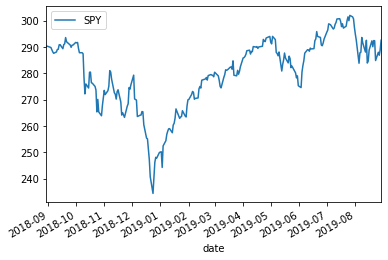

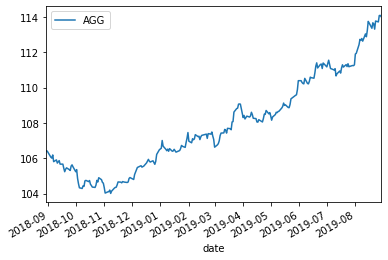

In [23]:
list_of_tickers = ["SPY", "AGG"]
serialized_ticker_file = "df_table.pickle"
df_table = {}
end_date = datetime.now()
start_date = end_date + timedelta(-365)

if os.path.exists(serialized_ticker_file):
    df_table = pickle.load( open( serialized_ticker_file, "rb" ) )
    print("Reading data on disk")
else:
    print("Making another request to iexfinance")
    for ticker in list_of_tickers:
        df = get_historical_data(ticker, start_date, end_date,  output_format='pandas')
        df_table[ticker] = df
        pickle.dump( df_table, open( "df_table.pickle", "wb" ) )
            
for ticker in df_table:
    df = df_table[ticker] 
    df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
    df.columns = [ticker]
    print(df.head())
    df.plot()

# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 100 iterations and generate at least 20 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 20 years

In [24]:
# Calculate the daily roi for the stocks
combined_df = None

for ticker in df_table:
    ticker_df = df_table[ticker].astype('float64').pct_change()
    combined_df = pd.concat([combined_df,ticker_df], axis="columns", join="inner")

combined_df.dropna(inplace=True)
print("Here is 'combined_df'")
combined_df.head()

Here is 'combined_df'


,SPY,AGG
date,,
2018-08-31,0.000034,-0.000094
2018-09-04,-0.001722,-0.003289
2018-09-05,-0.002691,-0.000471
2018-09-06,-0.003010,0.001698
2018-09-07,-0.001943,-0.003578


In [25]:
# Calculate volatility
volatility = {}

for ticker in list_of_tickers:
    volatility[ticker] = combined_df.std()[ticker]
    print(f"Volatility of {ticker} is {volatility[ticker]}")


Volatility of SPY is 0.010546086731997003
Volatility of AGG is 0.0018463740329823825


In [26]:
# Save the last day's closing price
last_price = {}

for ticker in list_of_tickers:
    last_price[ticker] = df_table[ticker][ticker][-1] 
    print(f"Last day's closing price of {ticker} is {last_price[ticker]}")

Last day's closing price of SPY is 292.58
Last day's closing price of AGG is 114.03


In [27]:
# [Ww] Calculate average daily returns, right? (@TODO I think this cell needs to be here.)
average_daily_return = {}

for ticker in list_of_tickers:
    average_daily_return[ticker] = combined_df[ticker].mean()
    print(f"Average daily return of {ticker} is {average_daily_return[ticker]}")

Average daily return of SPY is 8.675940922672076e-05
Average daily return of AGG is 0.00027800801176903177


In [28]:
# Calculate weighted portfolio returns
# This was maybe premature
# weights = [.6,.4]
# weighted_returns = combined_df.dot(weights)
# print(type(weighted_returns))
# weighted_returns.head()

In [29]:
# Setup the Monte Carlo Parameters
number_simulations = 1000
number_trading_days = 252 * 30
monte_carlo = pd.DataFrame()

In [30]:
# Run the Monte Carlo Simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

for n in range(number_simulations):
    for ticker in list_of_tickers:
        simulated_prices = [last_price[ticker]]
        for i in range(number_trading_days):
            simulated_price = simulated_prices[-1] * (1 + 
                                                      np.random.normal(average_daily_return[ticker], 
                                                                       volatility[ticker])
                                                     )
            simulated_prices.append(simulated_price)
        simulated_price_df[ticker] = pd.Series(simulated_prices)
    simulated_daily_returns = simulated_price_df.pct_change()
    weights = [0.60, 0.40]
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002174,0.992958,0.990547,0.996667,1.004573,1.010131,1.012614,0.991042,1.001323,0.999343,...,0.989029,1.005746,1.003815,0.995956,0.995646,1.002291,1.015793,1.003558,0.997310,0.996854
2,1.000626,0.993143,0.989422,1.003537,1.019227,0.999970,1.005761,1.009658,1.000634,0.993015,...,0.987802,1.013093,1.015511,0.999463,0.984984,0.995720,1.021897,1.006331,0.990036,0.992484
3,1.005609,0.996594,0.985718,1.003128,1.023379,0.987812,0.996506,0.996097,0.999446,1.004987,...,0.978462,1.015575,1.023634,0.989721,0.990282,0.994604,1.021431,1.011850,0.997193,0.992779
4,1.016112,1.000785,0.990406,0.990704,1.019626,0.988846,0.993141,0.989679,0.997934,0.999550,...,0.982642,1.013794,1.026027,1.004151,0.993016,0.984271,1.028886,1.008983,0.996016,1.008570


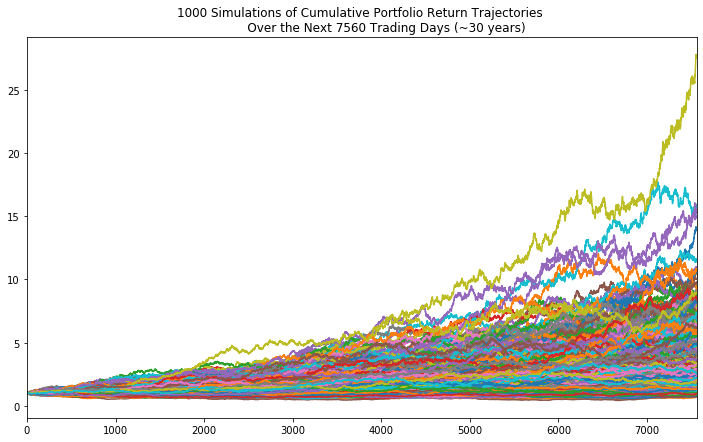

In [31]:
# Visualize the Simulation
plot_title = f"{number_simulations} Simulations of Cumulative Portfolio Return Trajectories \n \
            Over the Next {number_trading_days} Trading Days (~30 years)"
portfolio_cumulative_returns.plot(legend=None, title=plot_title, figsize=(12,7))

In [32]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    2.346650
1    3.253034
2    1.441726
3    2.604604
4    5.332288
Name: 7560, dtype: float64

In [33]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns.tail(1)

999    2.58863
Name: 7560, dtype: float64

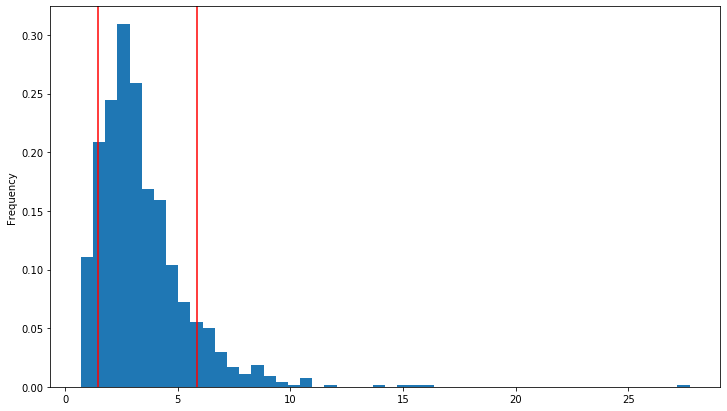

In [34]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.1, 0.9])
confidence_interval
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=50,figsize=(12,7))
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

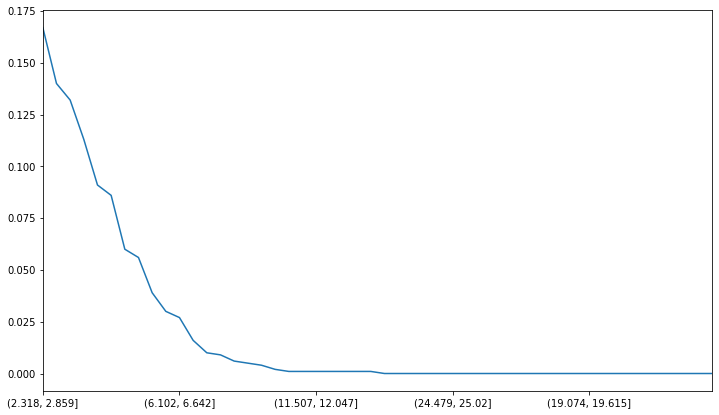

In [35]:
# Visualize the distribution of the ending returns
probability_distribution_of_ending_returns = ending_cumulative_returns.value_counts(bins=50) / len(ending_cumulative_returns)
probability_distribution_of_ending_returns.plot(figsize=(12,7))

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [36]:
initial_investment = 20_000
new_confidence_interval = ending_cumulative_returns.quantile(q=[0.05,0.5,0.95])
new_confidence_interval
ten = initial_investment + (initial_investment * new_confidence_interval.iloc[0])
fiddy = initial_investment + (initial_investment * new_confidence_interval.iloc[1])
nintey = initial_investment + (initial_investment * new_confidence_interval.iloc[2])
print(f"""
Expected cumulative returns at 30 years:
10th percentile => {ten:,.2f}
50th percentile => {fiddy:,.2f}
90th percentile => {nintey:,.2f}
""")


Expected cumulative returns at 30 years:
10th percentile => 42,618.34
50th percentile => 79,041.35
90th percentile => 158,035.51



### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [37]:
##
##  I'm not sure how this question is different from the previous.
##    this question has an initial investment, but lacks years
##    the former, lacks initial investment.. I just combined the two into a single 
##    cell, I hope that's ok. Also, the README says $50k

### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [38]:
yearly_withdraw_rate = ten * .04 
monthly_withdraw_rate = yearly_withdraw_rate / 12

monthly_income = 500
monthly_avg_expenses = 10_645.24
projected_yearly_income = 6_000

if (yearly_withdraw_rate > projected_yearly_income):
    print(f"Yearly withdrawls of 4%, {yearly_withdraw_rate:,.2f} is greater than projected yearly income {projected_yearly_income:,.2f}")
else:
    print(f"Yearly withdrawls of 4%, {yearly_withdraw_rate:,.2f} is less than projected yearly income {projected_yearly_income:,.2f}")
    


Yearly withdrawls of 4%, 1,704.73 is less than projected yearly income 6,000.00


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [39]:
new_initial_investment = 20_000 + 20_000 * .5
new_new_confidence_interval = ending_cumulative_returns.quantile(q=[0.1])
new_new_confidence_interval
new_ten = new_initial_investment + (new_initial_investment * new_new_confidence_interval.iloc[0])

new_yearly_withdraw_rate = new_ten * .04

if (new_yearly_withdraw_rate > projected_yearly_income):
    print(f"Yearly withdrawls of 4%, {new_yearly_withdraw_rate:,.2f} is greater than projected yearly income {projected_yearly_income:,.2f}")
else:
    print(f"Yearly withdrawls of 4%, {new_yearly_withdraw_rate:,.2f} is still less than projected yearly income {projected_yearly_income:,.2f}")
    


Yearly withdrawls of 4%, 2,964.08 is still less than projected yearly income 6,000.00


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
## I'm not sure what numbers to use for this.